 ## Heart Classification
 |Info | Details |
| ---  | --- |
|  DATA | heart_disease.csv |
|  DESCRIPTION | The data set contains measurements on 304 patients, consisting of factors that potentially indicate the presence or absence of heart disease. |
|PURPOSE | In this example, we will show different binary classification modeling techniques to predict the heart disease. |
| SOURCE | Adapted from "Heart Disease prediction Random forest Classifier https://www.kaggle.com/code/mruanova/heart-disease-prediction-random-forest-classifier by Mau Rua



#### Loading the heart_disease data.

In [2]:
title 'Predicting heart disease using different modeling techniques';

filename heart url 'https://raw.githubusercontent.com/rachelnisbet/JupyterCodingCanvas/main/heart_disease.csv';

proc import
    datafile=heart
    out=heart_disease dbms=csv replace;
run;


103  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
103! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml1.htm
104  
105  title 'Predicting heart disease using different modeling techniques';
106  
107  filename heart url 'https://raw.githubusercontent.com/rachelnisbet/JupyterCodingCanvas/main/heart_disease.csv';
108  

NOTE: The infile HEART is:
      Filename=https://raw.githubusercontent.com/rachelnisbet/JupyterCodingCanvas/main/heart_disease.csv,
      Local Host Name=sas-compute-server-eda058c2-17fb-4563-89a9-c1b7a0842c33-222,
      Local Host IP addr=10.244.1.78,
      Service Hostname Name=cdn-185-199-108-133.github.com,
      Service IP addr=185.199.108.133,
      Service Name=N/A,Service Portno=443,
      Lrecl=32767,Recfm=Variable

NOTE: 304 records were read from the infile HEART.
      The minimum record length was 33.
      The maximum record length was 36.
NOTE: The data set W

In [3]:
proc format;
    value heart_disease
        0="No heart disease"
        1="With heart disease"
    ;
    value sex_format
        0="Female"
        1="Male"
    ;
run;
data heart_disease;
    format target heart_disease. sex sex_format.;
    set heart_disease;
run;


173  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
173! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml2.htm
174  
175  proc format;
176      value heart_disease
177          0="No heart disease"
178          1="With heart disease"
179      ;
NOTE: Format HEART_DISEASE has been output.
180      value sex_format
181          0="Female"
182          1="Male"
183      ;
NOTE: Format SEX_FORMAT has been output.
184  run;

NOTE: PROCEDURE FORMAT used (Total process time):
      real time           0.00 seconds
      cpu time            0.02 seconds
      

185  data heart_disease;
186      format target heart_disease. sex sex_format.;
187      set heart_disease;
188  run;

NOTE: There were 304 observations read from the data set WORK.HEART_DISEASE.
NOTE: The data set WORK.HEART_DISEASE has 304 observations and 14 variables.
NOTE: DATA statement used (Total process time):
      real time       

#### Print a few rows to show the original data.

In [4]:
title2 'Portion of heart_disease data';
proc print data=heart_disease (obs=5); run;

Obs,target,sex,age,trestbps,chol,thalch,oldpeak,ca,cp,exang,slope,thal,restecg,fbs
1,No heart disease,Male,63,145,233,150,2.3,0,3,0,0,1,0,1
2,With heart disease,Male,67,160,286,108,1.5,3,0,1,1,2,0,0
3,With heart disease,Male,67,120,229,129,2.6,2,0,1,1,0,0,0
4,No heart disease,Male,37,130,250,187,3.5,0,2,0,0,2,1,0
5,No heart disease,Female,41,130,204,172,1.4,0,1,0,2,2,0,0


### Column Descriptions
| Variable  | Description |
| ---  | --- |
| age | age in years|
| sex| (1 = male; 0 = female)|
| cp| chest pain type|
| trestbps| resting blood pressure (in mm Hg on admission to the hospital)|
| chol| serum cholesterol in mg/dl|
| fbs| (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)|
| restecg | resting electrocardiographic results|
| thalch | maximum heart rate achieved|
| exang| exercise induced angina (1 = yes; 0 = no)|
| oldpeak| ST depression induced by exercise relative to rest|
| slope| the slope of the peak exercise ST segment|
| ca| number of major vessels (0-3) colored by fluoroscopy|
| thal| 3 = normal; 6 = fixed defect; 7 = reversable defect|
| target| refers to the presence of heart disease in the patient (1=yes, 0=no)|

#### Visualization of heart disease percentages through a pie chart
 - Use the TEMPLATE procedure to customize the pie chart.
 - Use the SGRENDER procedure to display the pie chart with the customized
   template
 - Show the overall heart disease percentage and the heart disease percentage
   within sex


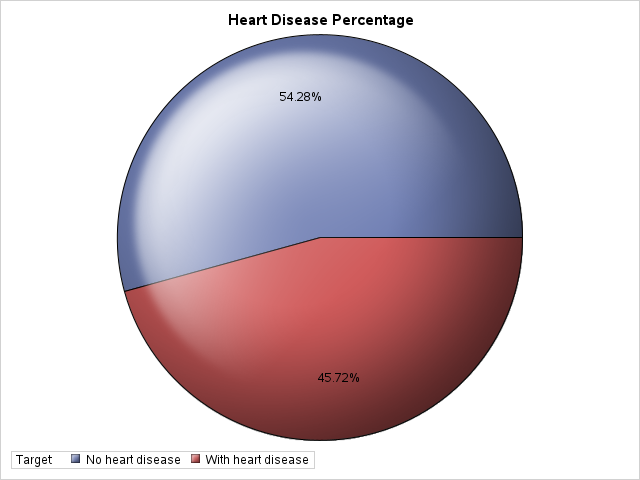
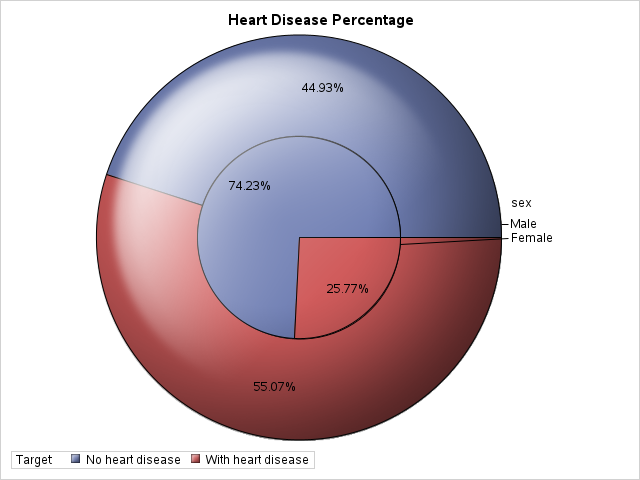

In [5]:
proc template;
    define statgraph simplepie;
        begingraph;
            entrytitle "Heart Disease Percentage";
            layout region;
                piechart category=target / name="p"
                     datalabelcontent=(percent)
                     datalabellocation=inside
                     dataskin=sheen;
                discretelegend "p" / title="Target" halign=left valign=bottom;
            endlayout;
        endgraph;
    end;
run;
title2 'Percentage of heart disease in the data';
proc sgrender data=heart_disease
              template=simplepie;
run;

proc template;
    define statgraph simplepie;
        begingraph;
            entrytitle "Heart Disease Percentage";
            layout region;
                piechart category=target / group=sex name="p"
                     datalabelcontent=(percent)
                     datalabellocation=inside
                     dataskin=sheen;
                discretelegend "p" / title="Target" halign=left valign=bottom;
            endlayout;
        endgraph;
    end;
run;
title2 'Percentage of heart disease by gender in the data';
proc sgrender data=heart_disease
              template=simplepie;
run;




#### Correlation Analysis
 To better understand how different factors contribute to heart disease
 and how the factors correlate with each other, we will use two different
 visualization tools: a correlation heatmap and a pairwise scatter plot.
 
  First, we use the CORR procedure to create the correlation matrix.


In [6]:
title2 'Output from the CORR procedure';
ods output PearsonCorr=corr;
proc corr data = heart_disease;
    var target--fbs;
run;

#### Sort and transpose the output from the CORR procedure for plotting a heatmap.

In [7]:
proc sort data=Corr;
    by variable;
run;
proc transpose data=Corr out=Corr_trans(rename=(COL1=Corr)) name=Correlation;
    var target--fbs;
    by variable;
run;
proc sort data=Corr_trans;
    by variable correlation;
run;

251  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
251! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml6.htm
252  
253  proc sort data=Corr;
254      by variable;
255  run;

NOTE: There were 14 observations read from the data set WORK.CORR.
NOTE: The data set WORK.CORR has 14 observations and 43 variables.
NOTE: PROCEDURE SORT used (Total process time):
      real time           0.00 seconds
      cpu time            0.00 seconds
      

256  proc transpose data=Corr out=Corr_trans(rename=(COL1=Corr)) name=Correlation;
257      var target--fbs;
258      by variable;
259  run;

NOTE: There were 14 observations read from the data set WORK.CORR.
NOTE: The data set WORK.CORR_TRANS has 196 observations and 3 variables.
NOTE: PROCEDURE TRANSPOSE used (Total process time):
      real time           0.00 seconds
      cpu time            0.00 seconds
      

260  proc sort data=Corr_trans;
261   

#### Use the SGPLOT procedure to produce the heatmap.
 - A few variables have strong positive or negative correlation with the "target"
   (heart disease). For example, "ca", "exang", and "oldpeak" show strong positive
   correlation with "target", while "thal" and "thalch" show strong negative
   correlation to "target".
 - Some variables also show strong correlation with each other. For example,
   "slope" has strong negative correlation with "oldpeak".


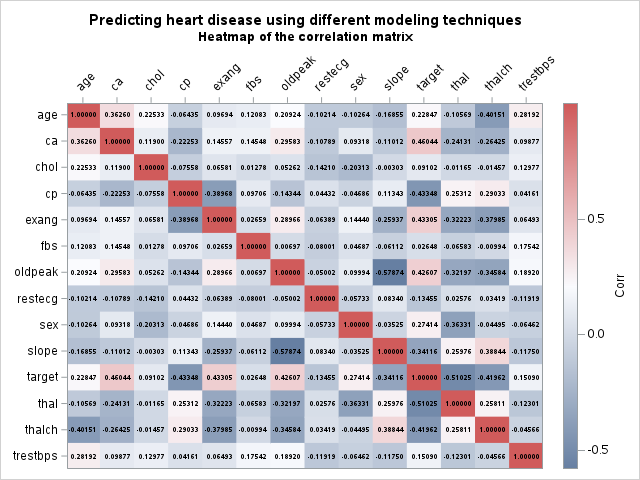

In [8]:
title2 'Heatmap of the correlation matrix';
proc sgplot data=Corr_trans noautolegend;
    heatmap x=variable y=Correlation / colorresponse=Corr discretex discretey x2axis;
    text x=Variable y=Correlation text=Corr  / textattrs=(size=5pt) x2axis;
    label correlation='Pearson Correlation';
    yaxis reverse display=(nolabel);
    x2axis display=(nolabel);
    gradlegend;
run;



#### Scatter Plot
The next tool we can use to visualize the relationships is the pairwise scatter plot. We can color the plotted points by "target" to visualize whether different distributions exist between "with heart disease" and "no heart disease" on each scatter plot.

For demonstration purposes, we pick only the variables that show strong correlation with "target". From the pairwise scatter plots, it is clear that the two groups ("With heart disease" vs "No heart disease") have different distribution patterns on these scatter plots.


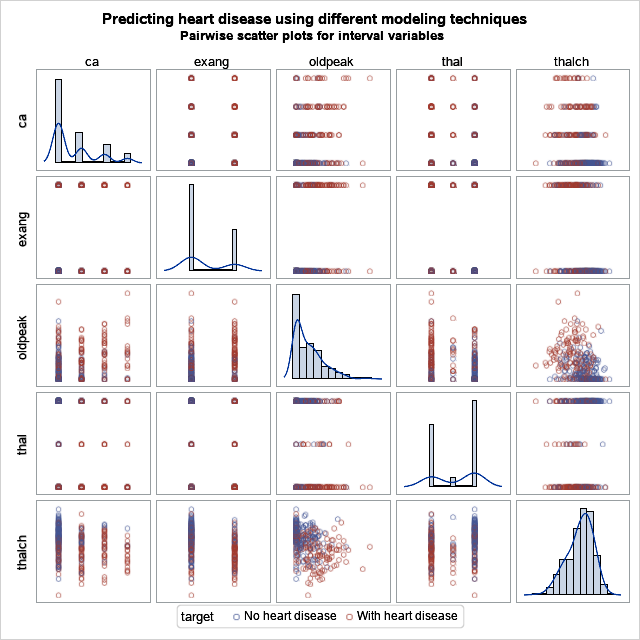

In [9]:
title2 'Pairwise scatter plots for interval variables';
proc sgscatter data=heart_disease;
     matrix ca exang oldpeak thal thalch /group=target diagonal=(histogram kernel);
run;

data heart_disease;
   set heart_disease;
   format target;
run;

In [15]:
cas;
caslib _all_ assign;
data casuser.heart_disease;
set heart_disease;
run;

345  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
345! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml14.htm
346  
347  cas;
NOTE: The session name identified with the SESSREF= SAS option is connected to Cloud Analytic Services. The default value for 
      SESSREF= is CASAUTO.
348  caslib _all_ assign;
NOTE: A SAS Library associated with a caslib can only reference library member names that conform to SAS Library naming conventions.
NOTE: CASLIB ACADEMIC for session CASAUTO will be mapped to SAS Library ACADEMIC.
NOTE: CASLIB ADML for session CASAUTO will be mapped to SAS Library ADML.
NOTE: CASLIB CASUSER(rachel.mclawhon@sas.com) for session CASAUTO will be mapped to SAS Library CASUSER.
NOTE: CASLIB CPML for session CASAUTO will be mapped to SAS Library CPML.
NOTE: CASLIB CRVA83 for session CASAUTO will be mapped to SAS Library CRVA83.
NOTE: CASLIB FVVF for session CASAUTO will be map

#### Partition
 Partition data into training and test sets.
 It is common to split the input data into training and test data. The
 PARTITION procedure is used to randomly partition HEART_DISEASE into
 HEART_DISEASE_TRAIN and HEART_DISEASE_TEST with an 80% to 20% ratio.

In [22]:
title2 'Create training and test data sets with the PARTITION procedure';
proc partition data=casuser.heart_disease seed=12345
    partind samppct=80;
    output out=casuser.heart_disease_part;
run;

data casuser.heart_disease_train(drop=_partind_);
    set casuser.heart_disease_part(where=(_partind_=1));
run;

data casuser.heart_disease_test(drop=_partind_);
    set casuser.heart_disease_part(where=(_partind_~=1));
run;




#### Modeling
 Finally, we will show 5 different classification modeling techniques by using 5 SAS procedures: LOGSELECT, TREESPLIT, GRADBOOST, FOREST, and SVMACHINE

#### LOGSELECT procedure

In [26]:
title2 'Build classification model using PROC LOGSELECT';
ods output FitStatistics=logfitstat;
proc logselect data=casuser.heart_disease_train technique=lbfgs maxiter=1000 partfit;
    class target ca--fbs;
    model target = age--fbs;
    savestate rstore=casuser.logstore;
run;

data _null_;
    set logfitstat;
    if rowid = 'MISCLASS' then
        call symputx('acc_train_logselect', (1-value));
run;

title3 'Score the model with ASTORE for the test data';
proc astore;
    score data=casuser.heart_disease_test rstore=casuser.logstore out=casuser.log_scoreout copyvars=(target);
run;



 #### Compute accuracy score:
 The percentage of patients in test
 data whose predicted heart disease
 status matched their actual status.

In [29]:
data _null_;
    retain matchSum 0;
    set casuser.log_scoreout end=last;
    match = (I_target = target);
    matchSum + match;
    if last then call symputx ('acc_test_logselect', (matchSum/_n_));
run;



617  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
617! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml28.htm
618  
619  data _null_;
620      retain matchSum 0;
621      set casuser.log_scoreout end=last;
622      match = (I_target = target);
623      matchSum + match;
624      if last then call symputx ('acc_test_logselect', (matchSum/_n_));
625  run;

NOTE: There were 61 observations read from the data set CASUSER.LOG_SCOREOUT.
NOTE: DATA statement used (Total process time):
      real time           0.03 seconds
      cpu time            0.02 seconds
      

626  
627  
628  ods html5 (id=saspy_internal) close;ods listing;
629  




####  TREESPLIT procedure


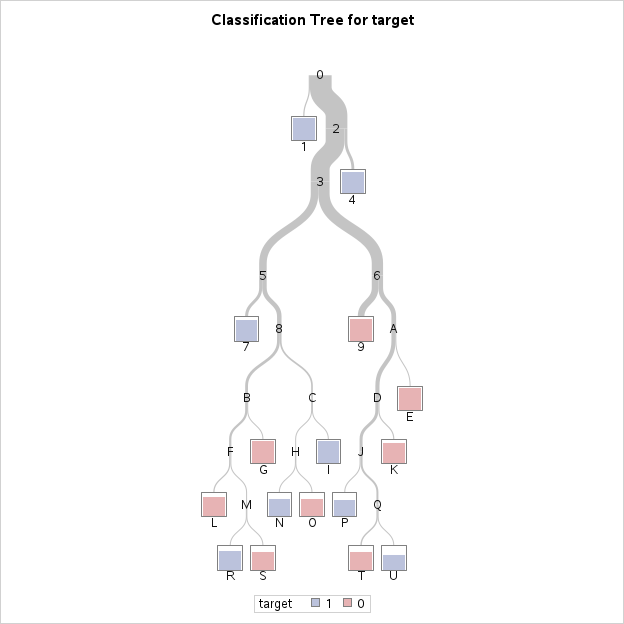
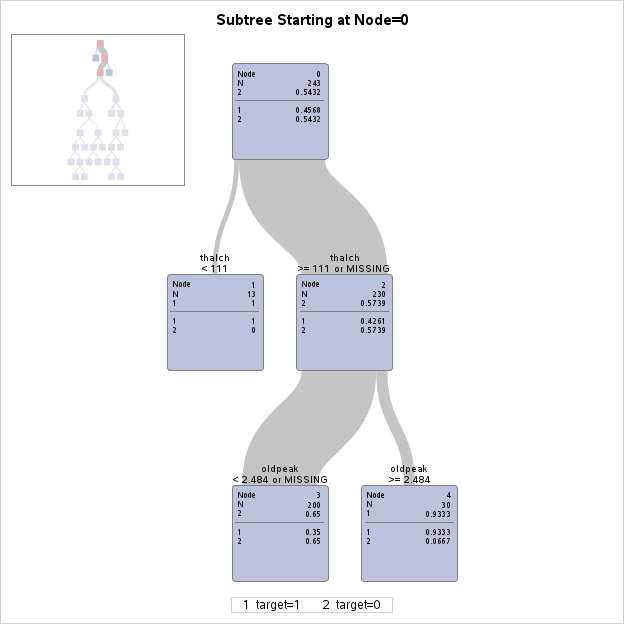

In [31]:
title2 'Build classification model using PROC TREESPLIT';
ods output treeperformance=treestat;
proc treesplit data=casuser.heart_disease_train;
    class target ca--fbs;
    model target = age--fbs;
    prune c45;
    savestate rstore=casuser.dtstore;
run;

data _null_;
    set treestat;
    call symputx('acc_train_treesplit', (1-MiscRate));
run;

title3 'Score the model with ASTORE for the test data';
proc astore;
    score data=casuser.heart_disease_test rstore=casuser.dtstore out=casuser.dt_scoreout copyvars=(target);
run;



#### Compute accuracy score:
 The percentage of patients in test
 data whose predicted heart disease
 status matched their actual status.

In [32]:
data _null_;
    retain matchSum 0;
    set casuser.dt_scoreout(keep=I_target target) end=last;
    match = (I_target = target);
    matchSum + match;
    if last then call symputx ('acc_test_treesplit', (matchSum/_n_));
run;



678  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
678! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml31.htm
679  
680  data _null_;
681      retain matchSum 0;
682      set casuser.dt_scoreout(keep=I_target target) end=last;
683      match = (I_target = target);
684      matchSum + match;
685      if last then call symputx ('acc_test_treesplit', (matchSum/_n_));
686  run;

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      683:14   
NOTE: There were 61 observations read from the data set CASUSER.DT_SCOREOUT.
NOTE: DATA statement used (Total process time):
      real time           0.03 seconds
      cpu time            0.03 seconds
      

687  
688  
689  ods html5 (id=saspy_internal) close;ods listing;
690  




#### GRADBOOST procedure

In [34]:
title2 'Build classification model using PROC GRADBOOST';
ods output FitStatistics=gbfitstat;
proc gradboost data=casuser.heart_disease_train;
    input age--oldpeak / level=interval;
    input ca--fbs / level=nominal;
    target target / level=nominal;
    savestate rstore=casuser.gbstore;
run;

data _null_;
    set gbfitstat end=last;
    if last then
       call symputx('acc_train_gradboost', (1-MiscTrain));
run;

title3 'Score the model with ASTORE for the test data';
proc astore;
    score data=casuser.heart_disease_test rstore=casuser.gbstore out=casuser.gb_scoreout copyvars=(target);
run;



#### Compute accuracy score:
 The percentage of patients in test
 data whose predicted heart disease
 status matched their actual status.

In [35]:
data _null_;
    retain matchSum 0;
    set casuser.gb_scoreout(keep=I_target target) end=last;
    match = (I_target = target);
    matchSum + match;
    if last then call symputx ('acc_test_gradboost', (matchSum/_n_));
run;



741  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
741! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml34.htm
742  
743  data _null_;
744      retain matchSum 0;
745      set casuser.gb_scoreout(keep=I_target target) end=last;
746      match = (I_target = target);
747      matchSum + match;
748      if last then call symputx ('acc_test_gradboost', (matchSum/_n_));
749  run;

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      746:14   
NOTE: There were 61 observations read from the data set CASUSER.GB_SCOREOUT.
NOTE: DATA statement used (Total process time):
      real time           0.04 seconds
      cpu time            0.02 seconds
      

750  
751  
752  ods html5 (id=saspy_internal) close;ods listing;
753  




#### FOREST procedure


In [36]:
title2 'Build classification model using PROC FOREST';
ods output modelInfo=forestModel;
proc forest data=casuser.heart_disease_train;
    input age--oldpeak / level=interval;
    input ca--fbs / level=nominal;
    target target / level=nominal;
    savestate rstore=casuser.forstore;
run;

data _null_;
    set forestModel;
    if prxmatch('m/misclassification/i', description) then
       call symputx('acc_train_forest', (1-value));
run;

title3 'Score the model with ASTORE for the test data';
proc astore;
    score data=casuser.heart_disease_test rstore=casuser.forstore out=casuser.for_scoreout copyvars=(target);
run;



#### Compute accuracy score:
 The percentage of patients in test
 data whose predicted heart disease
 status matched their actual status.

In [37]:
data _null_;
    retain matchSum 0;
    set casuser.for_scoreout(keep=I_target target) end=last;
    match = (I_target = target);
    matchSum + match;
    if last then call symputx ('acc_test_forest', (matchSum/_n_));
run;




779  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
779! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml36.htm
780  
781  data _null_;
782      retain matchSum 0;
783      set casuser.for_scoreout(keep=I_target target) end=last;
784      match = (I_target = target);
785      matchSum + match;
786      if last then call symputx ('acc_test_forest', (matchSum/_n_));
787  run;

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      784:14   
NOTE: There were 61 observations read from the data set CASUSER.FOR_SCOREOUT.
NOTE: DATA statement used (Total process time):
      real time           0.04 seconds
      cpu time            0.01 seconds
      

788  
789  
790  
791  ods html5 (id=saspy_internal) close;ods listing;
792  




#### SVMACHINE procedure


In [38]:
title2 'Build classification model using PROC SVMACHINE';
ods output FitStatistics=svmstat;
proc svmachine data=casuser.heart_disease_train;
    input age--oldpeak / level=interval;
    input ca--fbs / level=nominal;
    target target / level=nominal;
    savestate rstore=casuser.svmstore;
run;

data _null_;
    set svmstat;
    if statistic = 'Accuracy' then
       call symputx('acc_train_svmachine', training);
run;

title3 'Score the model with ASTORE for the test data';
proc astore;
    score data=casuser.heart_disease_test rstore=casuser.svmstore out=casuser.svm_scoreout copyvars=(target);
run;


#### Compute accuracy score:
 The percentage of patients in test
 data whose predicted heart disease
 status matched their actual status.

In [39]:
data _null_;
    retain matchSum 0;
    set casuser.svm_scoreout(keep=I_target target) end=last;
    match = (I_target = target);
    matchSum + match;
    if last then call symputx ('acc_test_svmachine', (matchSum/_n_));
run;



817  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
817! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml38.htm
818  
819  data _null_;
820      retain matchSum 0;
821      set casuser.svm_scoreout(keep=I_target target) end=last;
822      match = (I_target = target);
823      matchSum + match;
824      if last then call symputx ('acc_test_svmachine', (matchSum/_n_));
825  run;

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      822:14   
NOTE: There were 61 observations read from the data set CASUSER.SVM_SCOREOUT.
NOTE: DATA statement used (Total process time):
      real time           0.02 seconds
      cpu time            0.02 seconds
      

826  
827  
828  ods html5 (id=saspy_internal) close;ods listing;
829  




#### Comparison:
 We have completed the modeling and prediction using 5 different SAS Viya
 procedures for the HEART_DISEASE data set. We also recorded the training
 and test accuracy. In the section below, we will put all the recorded
 accuracy values together and use a bar-chart to display and compare them.


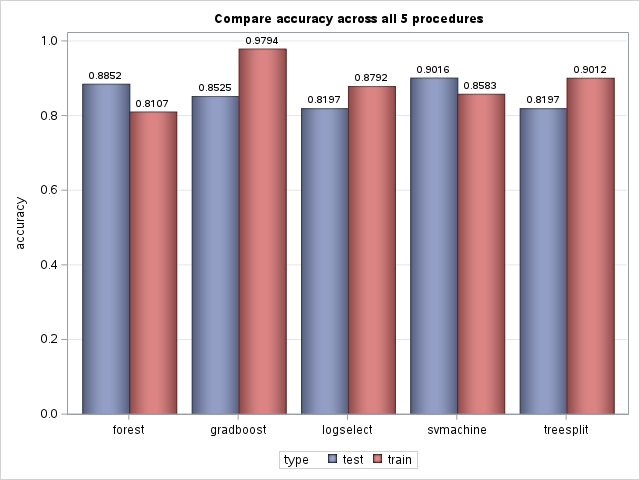

In [42]:

%macro CreateComparison;
    %let allprocs = logselect treesplit gradboost forest svmachine;
    data allMethods;
        length procname $16. type $8.;
        %do i = 1 %to %sysfunc(countw(&allprocs));
            %let currentProc = %scan(&allprocs,&i);
            procname = "&currentProc";
            type = "train";
            accuracy = &&&acc_train_&currentProc;
            output;
            procname = "&currentProc";
            type = "test";
            accuracy = &&&acc_test_&currentProc;
            output;
        %end;
    run;
    proc sgplot data=allMethods;
        vbar procname / response=accuracy group=type nostatlabel datalabel
                    groupdisplay=cluster dataskin=pressed;
        xaxis display=(nolabel);
        yaxis grid;
    run;
%mend;

title2 'Compare accuracy across all 5 procedures';
%CreateComparison;

title;